# Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import gc
import wandb
import random

#For deterministic behavious
seed = 42
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

/home/munish/.conda/envs/MyCondaEnv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
learning_rate = 1e-04
num_epochs = 30
batch_size = 16
img_resize = 560
crop_size = 512
mean, std = [0.4194, 0.4612, 0.3479], [0.2038, 0.1898, 0.2043]
base_model = 'resnet34'
p_img_aug = 0.5
loss_name = "dice_loss"
inv_transforms = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                    transforms.Normalize(mean = [-mean[0], -mean[1], -mean[2]],
                                        std = [ 1., 1., 1. ])])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting first experiment
wandb.init(project='scene_segmentation', name=f"{base_model}_{loss_name}")
wandb.config = {
    'batch_size': batch_size,
    'crop_size': crop_size,
    'mean': mean,
    'std': std,
    'num_epochs': num_epochs,
    'base_model': base_model,
    'p_img_aug': p_img_aug,
    'loss': loss_name,
    'metrics': 'iou_score'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniket_thomas (ms_research_project). Use `wandb login --relogin` to force relogin


## Helper Functions

In [3]:
# Calculate mean and std_dev for normalization
def mean_and_std(dataloader):
    channel_sum, channel_squared_sum = 0, 0
    for idx, (imgs, _) in tqdm(enumerate(dataloader, start = 1), total=len(dataloader)):
        imgs = imgs.to(device, non_blocking = True)
        channel_sum += torch.mean(imgs, dim = [0, 2, 3])
        channel_squared_sum += torch.mean(imgs**2, dim = [0, 2, 3])
    mean = channel_sum / (idx)
    std = (channel_squared_sum/(idx) - mean**2)**0.5
    return mean, std

## Loading data

In [4]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'val-org-img', valid_dir/'val-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [5]:
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 450, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

In [6]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 42
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

data/FloodNet-Supervised_v1.0/train/train-org-img/6960.jpg
data/FloodNet-Supervised_v1.0/train/train-label-img/6960_lab.png


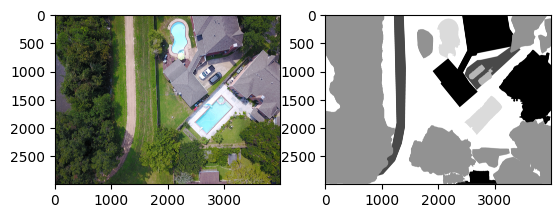

In [7]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [8]:
# unique_labels = []
# for img in tqdm(train_images):
#     mask_path = label_mask_path(train_mask_dir, img)
#     mask = np.asarray(Image.open(mask_path))
#     unique_label = np.unique(mask).tolist()
#     unique_labels.extend(unique_label)
# print(f"No of unique labels: {len(set(unique_labels))}")

In [9]:
class SatelliteDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, images, transforms = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, idx):
        current_img_path = self.images[idx]
        current_label_path = self.label_mask_path(current_img_path)
        img = np.asarray(Image.open(current_img_path)).copy() / 255.
        mask = np.asarray(Image.open(current_label_path)).copy()
        if self.transforms:
            transformed = self.transforms(image = img, mask = mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

    def label_mask_path(self, image_path):
        return self.masks_dir/f'{image_path.stem}_lab.png'

In [10]:
train_augmentation = A.Compose([A.LongestMaxSize(max_size=img_resize, interpolation=1),
                                A.PadIfNeeded(min_height=img_resize, min_width=img_resize),
                                A.HorizontalFlip(p = p_img_aug),
                                A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
train_dataset = SatelliteDataset(train_img_dir, train_mask_dir, train_images, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=8, pin_memory=True)

valid_augmentation = A.Compose([A.LongestMaxSize(max_size=crop_size, interpolation=1),
                                A.PadIfNeeded(min_height=crop_size, min_width=crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
valid_dataset = SatelliteDataset(valid_img_dir, valid_mask_dir, valid_images, valid_augmentation)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = True, num_workers=8, pin_memory=True)

In [11]:
print('No. of batches in train loader = ',len(trainloader))
print ('Size of training dataset = ',len(train_dataset) )

No. of batches in train loader =  91
Size of training dataset =  1445


In [12]:
print('No. of batches in train loader = ',len(validloader))
print ('Size of training dataset = ',len(valid_dataset) )

No. of batches in train loader =  29
Size of training dataset =  450


In [13]:
# mean_and_std(trainloader)

In [14]:
test_augmentation = A.Compose([A.LongestMaxSize(max_size=crop_size, interpolation=1),
                                A.PadIfNeeded(min_height=crop_size, min_width=crop_size),
                                # A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
test_dataset = SatelliteDataset(test_img_dir, test_mask_dir, test_images, test_augmentation)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)

In [15]:
print ('No. of batches in test loader = ',len(testloader))
print ('Size of testing dataset = ',len(test_dataset) )

No. of batches in test loader =  28
Size of testing dataset =  448


In [16]:
train_imgs, train_masks = next(iter(trainloader))
train_imgs.shape, train_masks.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [17]:
valid_imgs, valid_masks = next(iter(validloader))
valid_imgs.shape, valid_masks.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

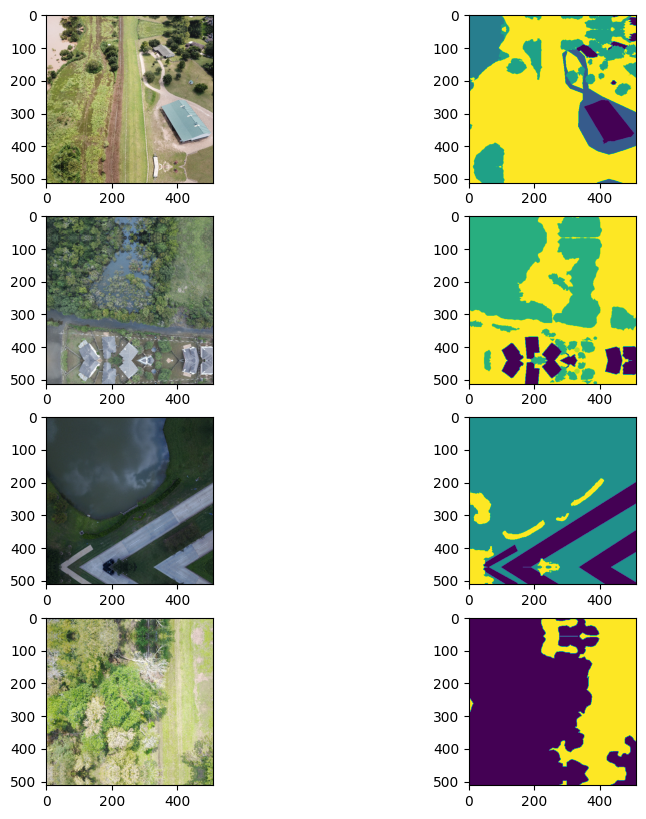

In [18]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    # Denormalizing input
    img = inv_transforms(train_imgs[i])
    img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), train_masks[i]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

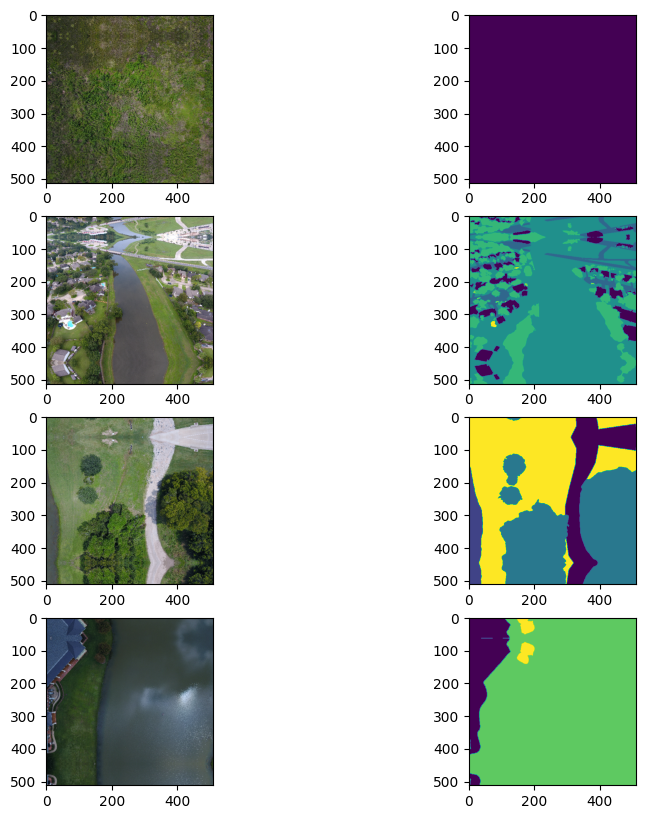

In [19]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    img = inv_transforms(valid_imgs[i])
    img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), valid_masks[i]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

### Segmentation Model

In [20]:
class SegmentationModel(nn.Module):
    def __init__(self, base_model):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(encoder_name = base_model, encoder_weights = 'imagenet', classes = 10)

    def forward(self, images):
        logits = self.arc(images)
        return logits

### Train and Test Function 

In [21]:
def train_fn(data_loader, model, optimizer, criterion, train = True):
    total_loss = 0.0
    pbar = tqdm(data_loader, total = len(data_loader), leave=False)
    for imgs,masks in pbar:
        imgs = imgs.to(device)
        masks = masks.to(device).to(torch.int64)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        if train:
            loss.backward()
            optimizer.step()
        pbar.set_postfix({'Loss': loss.item()})
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

def calculate_iou(dataloader, model):
    total_iou = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            out = model(imgs)
            out = torch.max(out, dim = 1)[1]
            tp, fp, fn, tn = smp.metrics.get_stats(out, masks, mode = 'multiclass', num_classes=10)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro-imagewise')
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction='macro-imagewise')
            f1_score = smp.metrics.recall(tp, fp, fn, tn, reduction="macro-imagewise")
            total_iou+=iou_score
            total_recall+=recall
            total_f1 += f1_score
        
        total_iou = total_iou/len(dataloader)
        total_recall = total_recall/len(dataloader)
        total_f1 = total_f1/len(dataloader)
        return total_iou, total_recall, total_f1

## Model Building

In [22]:
model = SegmentationModel(base_model)
model = model.to(device)
criterion = DiceLoss(mode = 'multiclass',classes=10)
# criterion = FocalLoss(mode = "multiclass", gamma = 2)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

### Training model

In [23]:
def log_visualization(dataloader, title):
    imgs, masks = next(iter(dataloader))
    imgs = imgs.to(device)
    preds = model(imgs)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    fig, axes = plt.subplots(len(imgs), 3, figsize = (10,25))
    for i in range(len(imgs)):
        # (H x W x C) -> (C x H x W)
        # Denormalizing input
        img = inv_transforms(imgs[i])
        img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), masks[i]
        img = np.clip(img, 0, 1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].imshow(img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].imshow(mask)
        _, pred_mask = torch.max(preds[i], dim = 0)
        pred_mask = pred_mask.cpu().detach()
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].imshow(pred_mask)
    wandb.log({title: fig})
    fig.clear()
    plt.close(fig)
log_visualization(validloader, 'Valid Sample (Before Training)')
log_visualization(trainloader, 'Train Sample (Before Training)');

<Figure size 640x480 with 0 Axes>

In [24]:
best_valid_iou = 0
train_losses, valid_losses = [], []
train_iou_scores, valid_iou_scores = [], []
for i in range(num_epochs):
    model.train()
    train_loss = train_fn (trainloader, model, optimizer, criterion, train = True)
    torch.cuda.empty_cache()
    gc.collect()
    model.eval()
    with torch.no_grad():
        valid_loss = train_fn (validloader, model, optimizer, criterion, train = False)
        train_iou_score, train_recall, train_f1 = calculate_iou(trainloader, model)
        valid_iou_score, valid_recall, valid_f1 = calculate_iou(validloader, model)
    if valid_iou_score > best_valid_iou:
        if i%5 == 0:
            torch.save(model.state_dict(),f'{base_model}_{loss_name}_{i}.pt')
        print("Model Saved")
        best_valid_iou = valid_iou_score
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    train_iou_scores.append(train_iou_score)
    valid_iou_scores.append(valid_iou_score)
    print (f"Epoch : {i+1}\nTrain Loss = {train_loss:.5f}, Train IOU Score = {train_iou_score:.4f}\nValid Loss = {valid_loss:.5f}, valid IOU Score = {valid_iou_score:.4f}")
    wandb.log({"Epoch": i+1, 'train_loss': train_loss, 'train_iou_score': train_iou_score, 'valid_iou_score':valid_iou_score, 'valid_loss': valid_loss,
               'train_recall': train_recall, 'train_f1': train_f1, 'valid_recall': valid_recall, 'valid_f1': valid_f1})
    if i%5 == 0:
        log_visualization(trainloader, f"Epoch: Train Sample")
        log_visualization(validloader, f"Epoch: Valid Sample")

 83%|████████▎ | 24/29 [00:41<00:02,  1.83it/s, Loss=0.599]

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('IOU Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.plot(train_iou_scores, 'r--', label = 'Train')
plt.plot(valid_iou_scores, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

In [ ]:
log_visualization(validloader, 'Valid Sample (After Training)')
log_visualization(trainloader, 'Train Sample (After Training)');